In [4]:
# 1) Imports & seed
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt  

np.random.seed(42)
random.seed(42)

# 2) Game data + helper
payoff = np.array([
    [[2, 2], [3, 0]], 
    [[0, 3], [4, 4]]
])

def get_payoff(player1_strategy, player2_strategy, player_id):
    return payoff[int(player1_strategy), int(player2_strategy), int(player_id)]

# 3) Constants
MEMORY_DISCOUNT = 0.9
TRUST_DISCOUNT  = 0.6
TRUST_SMOOTHING = 0.1
TRUST_MIN = 1.0
TRUST_MAX = 5.0

In [5]:
# ---------- Bayesian focal agent (works with your current partners) ----------
class BayesianFocalAgent:
    def __init__(self, alpha0=None, beta0=None, x0=1/3, T0=1.0):
        # prior mapped from your (x0, T0) for comparability
        if alpha0 is None or beta0 is None:
            alpha0 = 1 + x0 * T0
            beta0  = 1 + (1 - x0) * T0
        self.alpha = float(alpha0)
        self.beta  = float(beta0)

    @property
    def posterior_mean(self):
        return self.alpha / (self.alpha + self.beta)

    def make_decision(self) -> int:
        # same EV rule as your FocalAgent, but using posterior_mean for p
        p = self.posterior_mean
        a00 = get_payoff(0,0,0); a01 = get_payoff(0,1,0)
        a10 = get_payoff(1,0,0); a11 = get_payoff(1,1,0)
        E_V_hare = (1 - p) * a00 + p * a01
        E_V_stag = (1 - p) * a10 + p * a11
        return 1 if E_V_stag > E_V_hare else 0

    def update(self, partner_choice:int):
        # standard Beta–Binomial update
        self.alpha += partner_choice
        self.beta  += (1 - partner_choice)

In [6]:
# 5) Partners (belief-driven)
class BeliefDrivenPartnerBase:
    """
    Partner maintains its own beliefs (x_hat in [0,1], t_hat in [t_min,t_max])
    and updates via recency-weighted actions and consistency-based trust.
    """
    def __init__(self, 
                 u_i: float = None, 
                 t0: float = 1.0,
                 eta: float = 0.1, 
                 noise_sigma: float = 0.02, 
                 memory_discount: float = MEMORY_DISCOUNT,
                 trust_discount: float = TRUST_DISCOUNT,
                 trust_smoothing: float = TRUST_SMOOTHING,
                 t_min: float = TRUST_MIN, 
                 t_max: float = TRUST_MAX):
        if u_i is not None and not 0 <= u_i <= 1:
            raise ValueError("u_i must be between 0 and 1")
        if not t_min <= t0 <= t_max:
            raise ValueError("t0 must be between t_min and t_max")

        self.x_hat = u_i if u_i is not None else 1 - ((get_payoff(0,0,0) - get_payoff(1,0,0)) /
                                                  ((get_payoff(0,0,0) - get_payoff(1,0,0)) + 
                                                   (get_payoff(1,1,0) - get_payoff(0,1,0))))
        self.t_hat = float(t0)
        self.eta = eta
        self.noise_sigma = noise_sigma
        self.memory_discount = memory_discount
        self.trust_discount = trust_discount
        self.trust_smoothing = trust_smoothing
        self.t_min = t_min
        self.t_max = t_max
        self.match_history = []
        self.obs_actions = []

    def _expected_choice_from_signal(self, x): return 1 if x > 0.5 else 0

    def _target_trust_from_history(self):
        if not self.match_history:
            return 1.0
        weights = [self.trust_discount ** i for i in range(len(self.match_history)-1, -1, -1)]
        consistency = sum(m*w for m, w in zip(self.match_history, weights)) / sum(weights)
        return self.t_min + (self.t_max - self.t_min) * consistency

    def _update_trust(self, observed_action):
        expected_choice = self._expected_choice_from_signal(self.x_hat)
        match = 1 if observed_action == expected_choice else 0

        # symmetry with FocalAgent: compute target from existing history first
        T_target = self._target_trust_from_history()
        self.match_history.append(match)

        new_t = (1 - self.trust_smoothing) * self.t_hat + self.trust_smoothing * T_target
        self.t_hat = float(np.clip(new_t, self.t_min, self.t_max))

    def _update_signal(self):
        if self.obs_actions:
            weights = [self.memory_discount ** i for i in range(len(self.obs_actions)-1, -1, -1)]
            P_obs = sum(a*w for a, w in zip(self.obs_actions, weights)) / sum(weights)
        else:
            P_obs = self.x_hat
        noise = np.random.normal(0, self.noise_sigma)
        self.x_hat = float(np.clip(self.x_hat + self.eta * (P_obs - self.x_hat) + noise, 0.0, 1.0))

    # API
    def decide(self, round_num:int, last_agent_choice:int|None=None) -> int:
        raise NotImplementedError
    def observe(self, focal_agent_action:int):
        self.obs_actions.append(int(focal_agent_action))
        self._update_trust(focal_agent_action)
        self._update_signal()

class AdaptivePartner(BeliefDrivenPartnerBase):
    def decide(self, round_num, last_agent_choice=None):
        return 1 if self.x_hat > 0.5 else 0

class StrategicCheaterPartner(BeliefDrivenPartnerBase):
    def __init__(self, t_threshold=2.5, **kwargs):
        super().__init__(**kwargs); self.t_threshold = t_threshold
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.t_hat > self.t_threshold else 1

class ExpectationViolationPartner(BeliefDrivenPartnerBase):
    """“chooses the opposite of its forecast of the agent’s action.”"""
    def decide(self, round_num, last_agent_choice=None):
        return 0 if self.x_hat > 0.5 else 1

In [7]:

# 6) Partners (fixed strategies)

class PeriodicCheaterPartner:
    """
    Cooperate for `cycle_length` rounds, then defect for `cheat_duration` rounds, repeat.
    """
    def __init__(self, cycle_length=6, cheat_duration=2):
        self.cycle_length = cycle_length
        self.cheat_duration = cheat_duration
    def decide(self, round_num, last_agent_choice=None):
        return 1 if (round_num % (self.cycle_length + self.cheat_duration)) < self.cycle_length else 0
    def observe(self, focal_agent_action:int):
        pass  # no learning

class SingleCyclePartner:
    """
    Cooperate for the first `cooperate_rounds` rounds, then defect thereafter.
    """
    def __init__(self, cooperate_rounds=30):
        self.cooperate_rounds = cooperate_rounds
    def decide(self, round_num, last_agent_choice=None):
        return 1 if round_num < self.cooperate_rounds else 0
    def observe(self, focal_agent_action:int):
        pass
class ProbabilisticPartner: 
    """
    Cooperate with a fixed probability.
    """
    def __init__(self, cooperate_prob=0.7):
        if not 0 <= cooperate_prob <= 1:
            raise ValueError("cooperate_prob must be in [0,1]")
        self.cooperate_prob = cooperate_prob
    def decide(self, round_num, last_agent_choice=None):
        return 1 if random.random() < self.cooperate_prob else 0
    def observe(self, focal_agent_action:int):
        pass
class TitForTatCooperatePartner:
    """
    Start by cooperating; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 1 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class TitForTatDefectPartner:
    """
    Start by defecting; afterwards mirror the focal agent's last action.
    """
    def decide(self, round_num, last_agent_choice=None):
        return 0 if last_agent_choice is None else int(last_agent_choice)
    def observe(self, focal_agent_action:int):
        pass

class AlwaysCollaboratePartner:
    def decide(self, round_num, last_agent_choice=None):
        return 1
    def observe(self, focal_agent_action:int):
        pass

class AlwaysDefectPartner:
    def decide(self, round_num, last_agent_choice=None):
        return 0
    def observe(self, focal_agent_action:int):
        pass

class RandomPartner:
    def decide(self, round_num, last_agent_choice=None):
        return random.choice([0, 1])
    def observe(self, focal_agent_action:int):
        pass

In [8]:
# 7) Simulation
def run_bayesian_vs_partner(
    num_rounds: int = 70,
    partner_obj = None,
    initial_last_choice: int = 1,
    x0: float = 1/3,
    T0: float = 1.0
) -> pd.DataFrame:
    if partner_obj is None:
        raise ValueError("Provide a partner_obj instance")

    agent = BayesianFocalAgent(x0=x0, T0=T0)
    results = []
    last_agent_choice = initial_last_choice

    for round_num in range(num_rounds):
        agent_choice = agent.make_decision()

        # partner uses its own belief state; no reference to agent internals
        partner_choice = partner_obj.decide(round_num, last_agent_choice)

        # update Bayesian agent from partner's action
        agent.update(partner_choice)

        # partner learns from the focal agent's action (same as your dual-state runs)
        partner_obj.observe(agent_choice)

        last_agent_choice = agent_choice

        results.append((
            round_num + 1, 
            agent_choice, 
            partner_choice, 
            agent.posterior_mean, 
            agent.alpha, 
            agent.beta, 
            agent.alpha + agent.beta - 2.0  # concentration = "confidence" analog
        ))

    return pd.DataFrame(results, columns=[
        "Round","Agent_Choice","Partner_Choice",
        "Posterior_Mean","Alpha","Beta","Concentration"
    ])

In [9]:
# Set simulation parameters
num_rounds = 70  
discount_factor = 0.6 
trust_smoothing = 0.1  

In [10]:
# Run simulations with all partner strategies
sim_results_cheating = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=6, cheat_duration=2))

sim_results_cheating_partner_cycle = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30))

sim_results_probabilistic = run_bayesian_vs_partner(
    num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7))

sim_results_strategic_cheater = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner())

sim_results_tit_for_tat_coop = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1)

sim_results_tit_for_tat_defect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0)

sim_results_collab = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner())

sim_results_defect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner())

sim_results_random = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=RandomPartner())

sim_results_adaptive = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AdaptivePartner())

sim_results_expect_violation = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner())

In [11]:
df_bayes_collab = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysCollaboratePartner())

df_bayes_defect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AlwaysDefectPartner())

df_bayes_random = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=RandomPartner())

df_bayes_prob = run_bayesian_vs_partner(
    num_rounds=num_rounds,
    partner_obj=ProbabilisticPartner(cooperate_prob=0.7))

df_bayes_cheating = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=PeriodicCheaterPartner(cycle_length=4, cheat_duration=2))

df_bayes_cheating_partner_cycle = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=SingleCyclePartner(cooperate_rounds=30))

df_bayes_tft_c = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatCooperatePartner(),
    initial_last_choice=1)

df_bayes_tft_d = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=TitForTatDefectPartner(),
    initial_last_choice=0)

df_bayes_adaptive = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=AdaptivePartner())

df_bayes_strat = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=StrategicCheaterPartner(t_threshold=2.5))

df_bayes_expect = run_bayesian_vs_partner(
    num_rounds=num_rounds, 
    partner_obj=ExpectationViolationPartner())

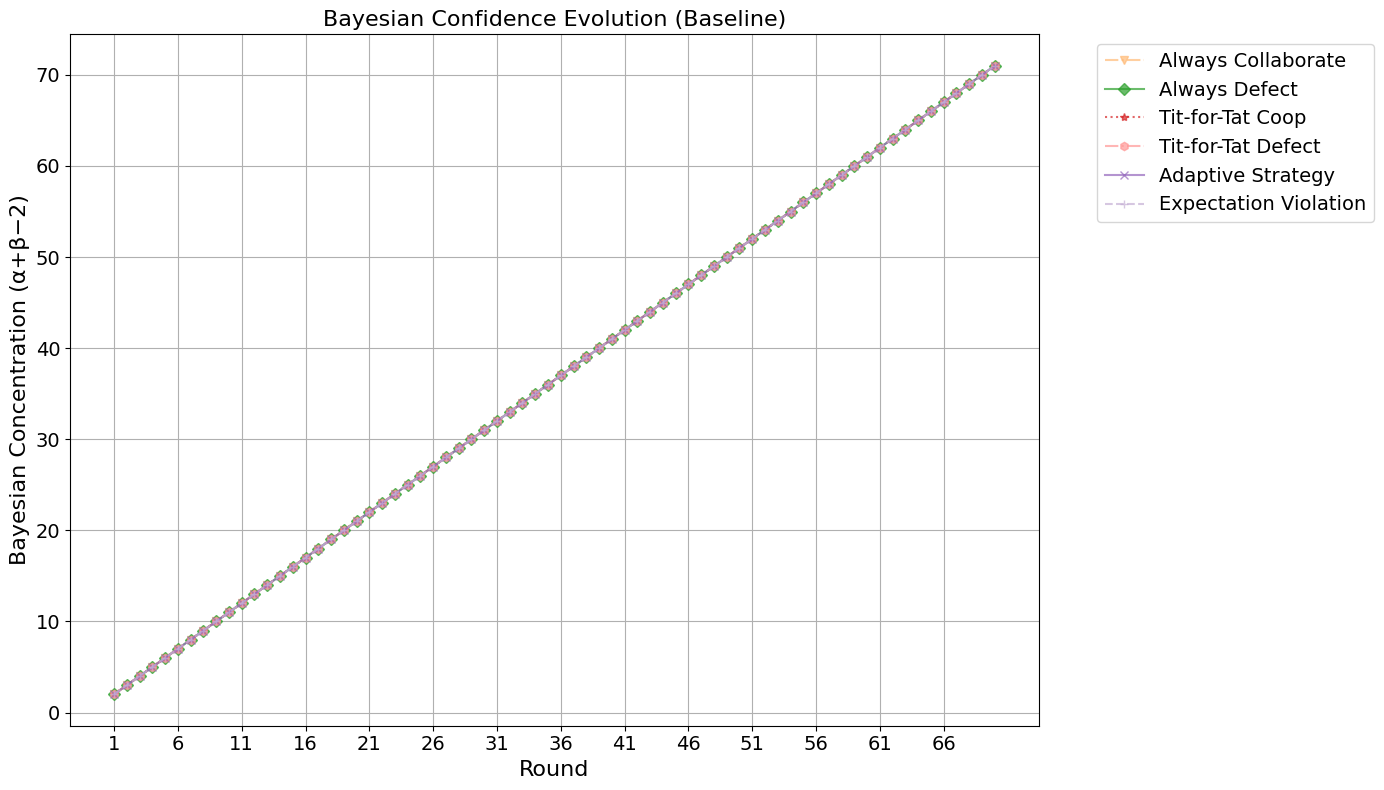

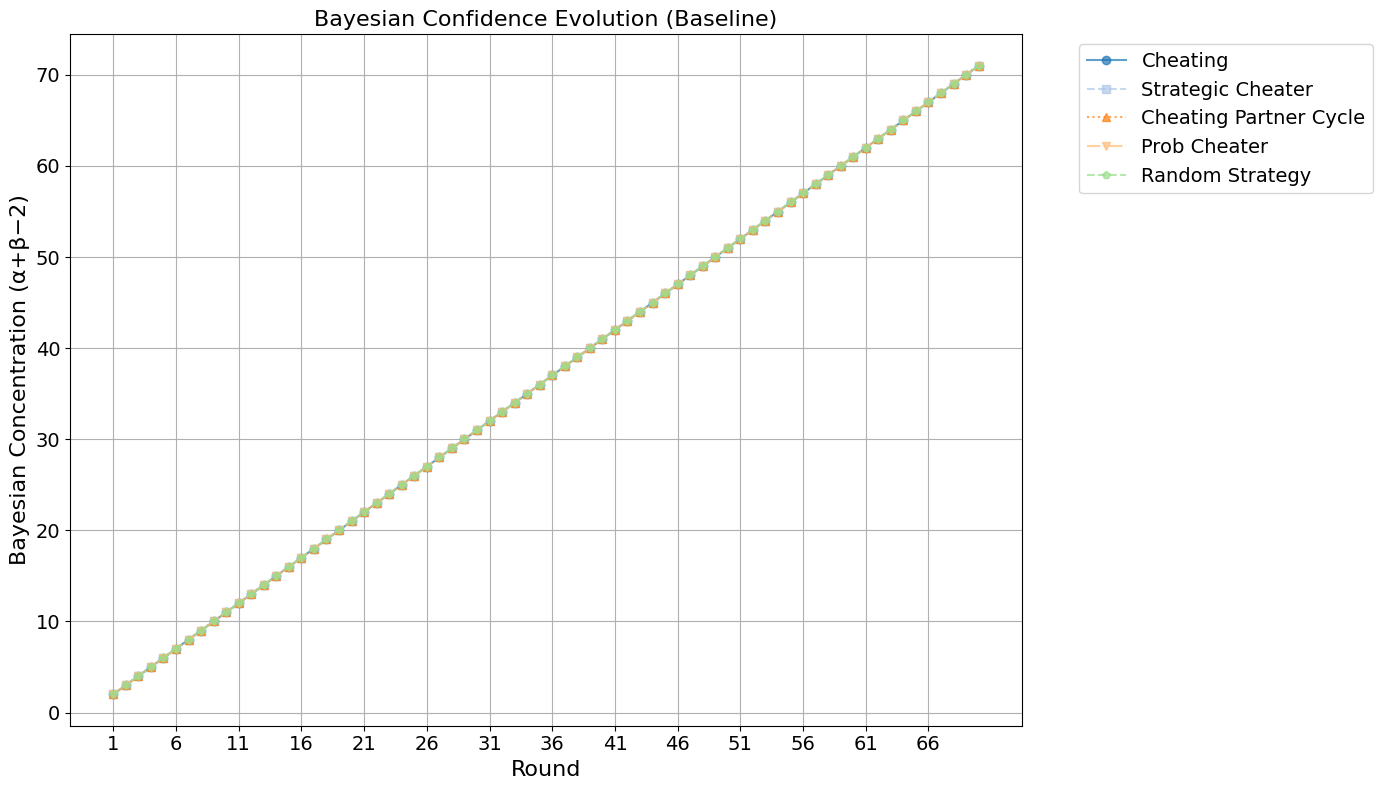

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# same palette and styles you used
colors = sns.color_palette("tab20", 10)
line_styles = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']
markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'x', '+']

# ---------- Confidence/Trust Evolution: cooperative-ish set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_collab["Round"], df_bayes_collab["Concentration"], label="Always Collaborate",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_defect["Round"], df_bayes_defect["Concentration"], label="Always Defect",
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_bayes_tft_c["Round"], df_bayes_tft_c["Concentration"], label="Tit-for-Tat Coop",
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_bayes_tft_d["Round"], df_bayes_tft_d["Concentration"], label="Tit-for-Tat Defect",
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_bayes_adaptive["Round"], df_bayes_adaptive["Concentration"], label="Adaptive Strategy",
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_bayes_expect["Round"], df_bayes_expect["Concentration"], label="Expectation Violation",
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Concentration (α+β−2)", fontsize=16)
plt.title("Bayesian Confidence Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# ---------- Confidence/Trust Evolution: adversarial/noisy set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_cheating["Round"], df_bayes_cheating["Concentration"], label="Cheating",
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)

plt.plot(df_bayes_strat["Round"], df_bayes_strat["Concentration"], label="Strategic Cheater",
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)

plt.plot(df_bayes_cheating_partner_cycle["Round"], df_bayes_cheating_partner_cycle["Concentration"], label="Cheating Partner Cycle",
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)

plt.plot(df_bayes_prob["Round"], df_bayes_prob["Concentration"], label="Prob Cheater",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_random["Round"], df_bayes_random["Concentration"], label="Random Strategy",
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Concentration (α+β−2)", fontsize=16)
plt.title("Bayesian Confidence Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


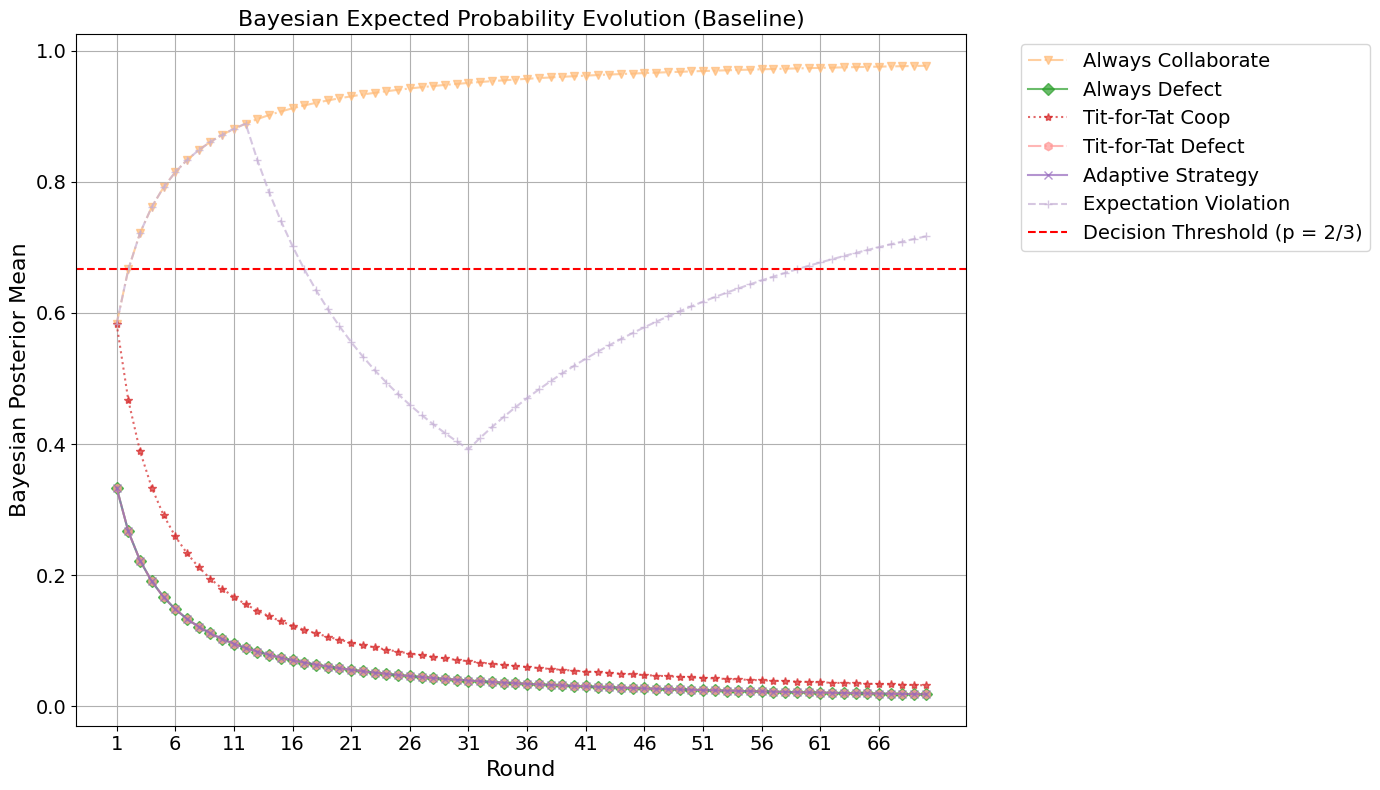

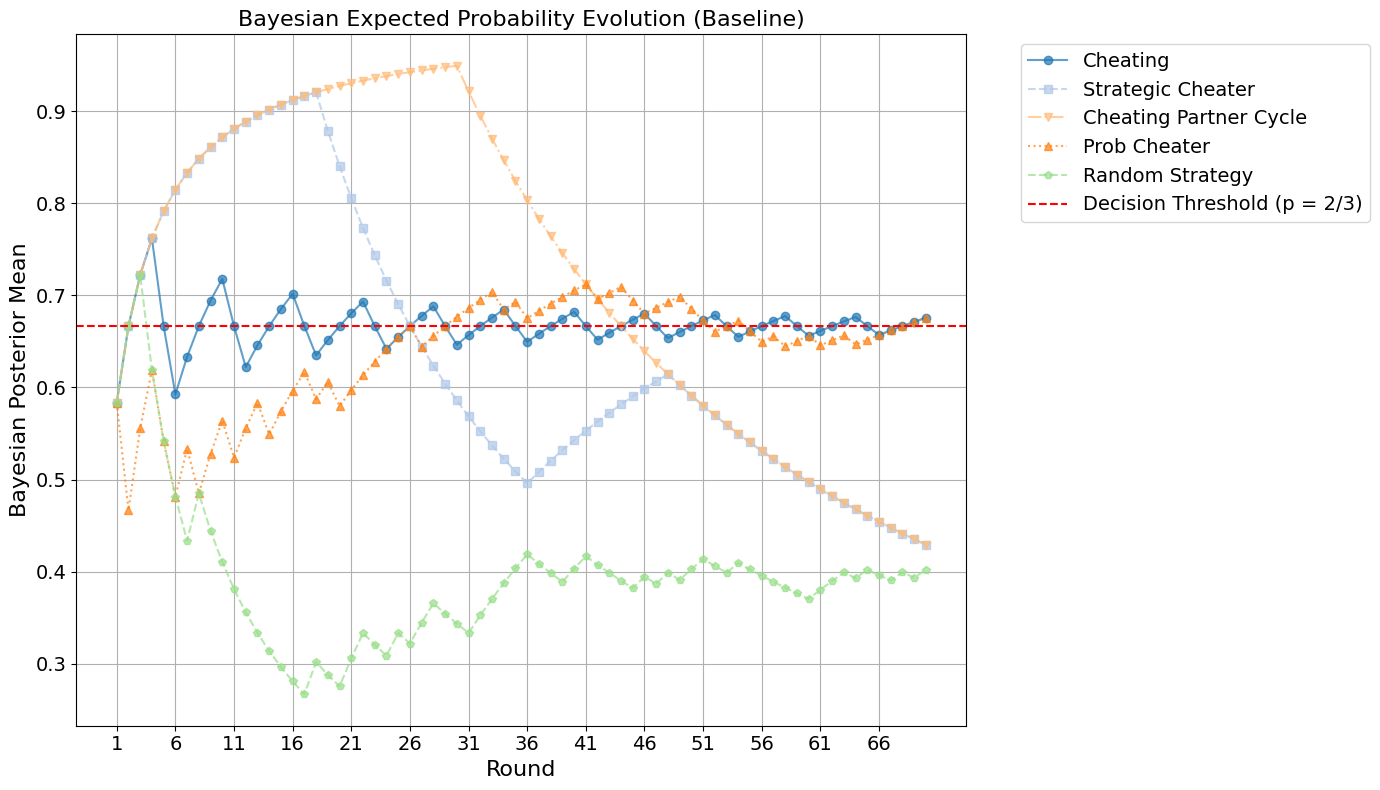

In [20]:
# ---------- Expected Probability (Bayes) Evolution: cooperative-ish set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_collab["Round"], df_bayes_collab["Posterior_Mean"], label="Always Collaborate",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)

plt.plot(df_bayes_defect["Round"], df_bayes_defect["Posterior_Mean"], label="Always Defect",
         color=colors[4], linestyle=line_styles[4], marker=markers[4], alpha=0.7)

plt.plot(df_bayes_tft_c["Round"], df_bayes_tft_c["Posterior_Mean"], label="Tit-for-Tat Coop",
         color=colors[6], linestyle=line_styles[6], marker=markers[6], alpha=0.7)

plt.plot(df_bayes_tft_d["Round"], df_bayes_tft_d["Posterior_Mean"], label="Tit-for-Tat Defect",
         color=colors[7], linestyle=line_styles[7], marker=markers[7], alpha=0.7)

plt.plot(df_bayes_adaptive["Round"], df_bayes_adaptive["Posterior_Mean"], label="Adaptive Strategy",
         color=colors[8], linestyle=line_styles[8], marker=markers[8], alpha=0.7)

plt.plot(df_bayes_expect["Round"], df_bayes_expect["Posterior_Mean"], label="Expectation Violation",
         color=colors[9], linestyle=line_styles[9], marker=markers[9], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# ---------- Expected Probability (Bayes) Evolution: adversarial/noisy set ----------
plt.figure(figsize=(14, 8))
plt.plot(df_bayes_cheating["Round"], df_bayes_cheating["Posterior_Mean"], label="Cheating",
         color=colors[0], linestyle=line_styles[0], marker=markers[0], alpha=0.7)
plt.plot(df_bayes_strat["Round"], df_bayes_strat["Posterior_Mean"], label="Strategic Cheater",
         color=colors[1], linestyle=line_styles[1], marker=markers[1], alpha=0.7)
plt.plot(df_bayes_cheating_partner_cycle["Round"], df_bayes_cheating_partner_cycle["Posterior_Mean"], label="Cheating Partner Cycle",
         color=colors[3], linestyle=line_styles[3], marker=markers[3], alpha=0.7)
plt.plot(df_bayes_prob["Round"], df_bayes_prob["Posterior_Mean"], label="Prob Cheater",
         color=colors[2], linestyle=line_styles[2], marker=markers[2], alpha=0.7)
plt.plot(df_bayes_random["Round"], df_bayes_random["Posterior_Mean"], label="Random Strategy",
         color=colors[5], linestyle=line_styles[5], marker=markers[5], alpha=0.7)

plt.axhline(2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Round", fontsize=16)
plt.ylabel("Bayesian Posterior Mean", fontsize=16)
plt.title("Bayesian Expected Probability Evolution (Baseline)", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.grid()
plt.xticks(ticks=np.arange(1, num_rounds + 1, step=5), fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


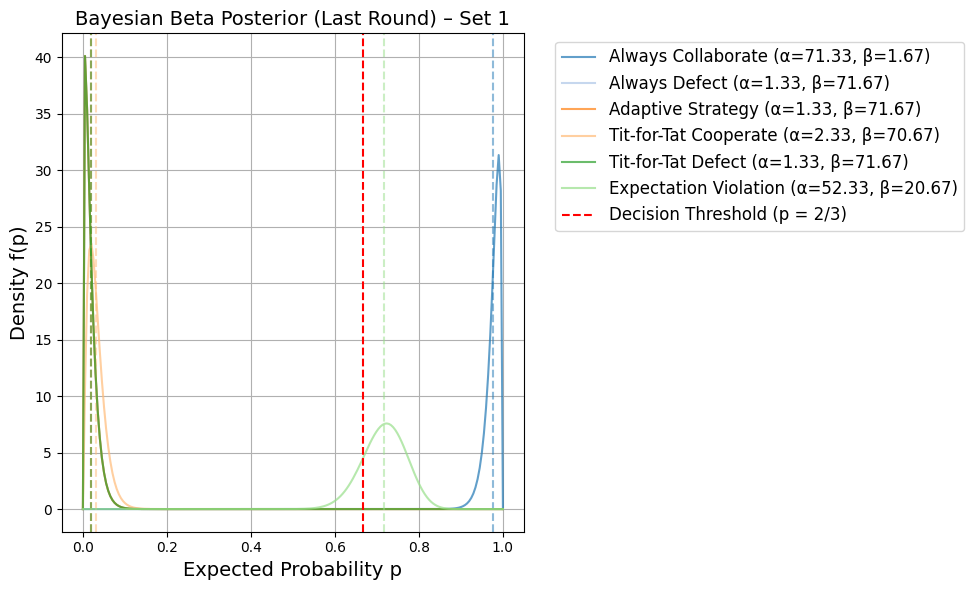

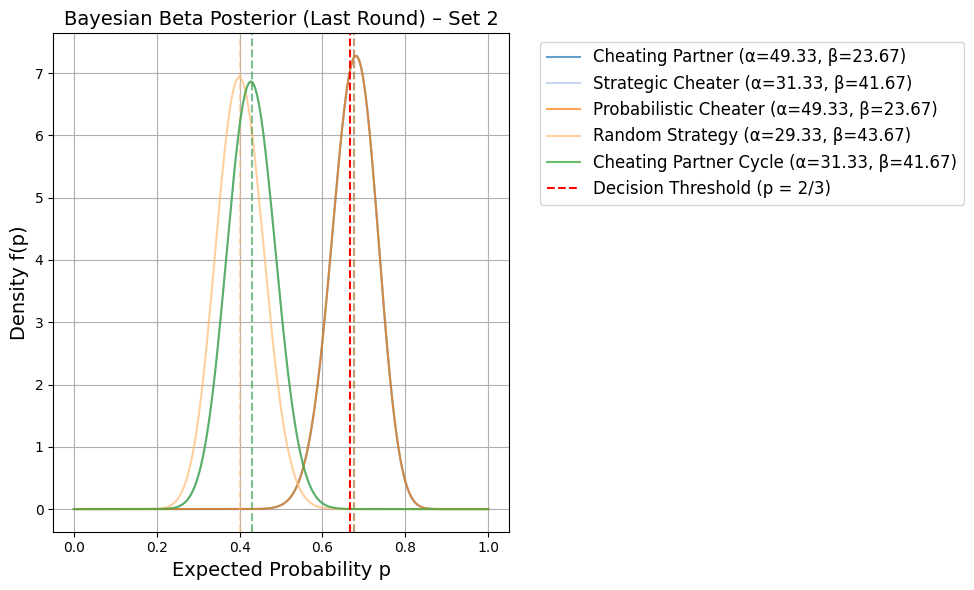

In [14]:
from scipy import stats

# Pick the same sets you used earlier
strategies_bayes_1 = [
    ("Always Collaborate", df_bayes_collab),
    ("Always Defect", df_bayes_defect),
    ("Adaptive Strategy", df_bayes_adaptive),
    ("Tit-for-Tat Cooperate", df_bayes_tft_c),
    ("Tit-for-Tat Defect", df_bayes_tft_d),
    ("Expectation Violation", df_bayes_expect)
]

# --- Plot Beta PDFs for set 1 ---
p = np.linspace(0, 1, 200)
plt.figure(figsize=(10, 6))
colors = sns.color_palette("tab20", 10)

for idx, (name, dfb) in enumerate(strategies_bayes_1):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    # Posterior mean (vertical line)
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) – Set 1", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot Beta PDFs for set 2 (adversarial/noisy) ---
strategies_bayes_2 = [
    ("Cheating Partner", df_bayes_cheating),
    ("Strategic Cheater", df_bayes_strat),
    ("Probabilistic Cheater", df_bayes_prob),
    ("Random Strategy", df_bayes_random),
    ("Cheating Partner Cycle", df_bayes_cheating_partner_cycle)
]

plt.figure(figsize=(10, 6))
for idx, (name, dfb) in enumerate(strategies_bayes_2):
    last = dfb.iloc[-1]
    alpha, beta = last["Alpha"], last["Beta"]
    E_p = last["Posterior_Mean"]
    plt.plot(p, stats.beta.pdf(p, alpha, beta),
             label=f"{name} (α={alpha:.2f}, β={beta:.2f})",
             alpha=0.7, color=colors[idx])
    plt.axvline(x=E_p, linestyle='--', alpha=0.5, color=colors[idx])

plt.axvline(x=2/3, color='red', linestyle='--', label='Decision Threshold (p = 2/3)')
plt.xlabel("Expected Probability p", fontsize=14)
plt.ylabel("Density f(p)", fontsize=14)
plt.title("Bayesian Beta Posterior (Last Round) – Set 2", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()


In [15]:
print("Bayesian – Decision-Making Trends in the Last Round:")
for name, dfb in strategies_bayes_1:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")

for name, dfb in strategies_bayes_2:
    last = dfb.iloc[-1]
    last_choice = last["Agent_Choice"]
    last_p = last["Posterior_Mean"]
    print(f"{name}: p = {last_p:.3f}, Choice = {'Stag' if last_choice == 1 else 'Hare'}")


Bayesian – Decision-Making Trends in the Last Round:
Always Collaborate: p = 0.977, Choice = Stag
Always Defect: p = 0.018, Choice = Hare
Adaptive Strategy: p = 0.018, Choice = Hare
Tit-for-Tat Cooperate: p = 0.032, Choice = Hare
Tit-for-Tat Defect: p = 0.018, Choice = Hare
Expectation Violation: p = 0.717, Choice = Stag
Cheating Partner: p = 0.676, Choice = Stag
Strategic Cheater: p = 0.429, Choice = Hare
Probabilistic Cheater: p = 0.676, Choice = Stag
Random Strategy: p = 0.402, Choice = Hare
Cheating Partner Cycle: p = 0.429, Choice = Hare


In [16]:
def add_payoffs(df):
    df = df.copy()
    p1 = df["Agent_Choice"].astype(int).to_numpy()
    p2 = df["Partner_Choice"].astype(int).to_numpy()
    df["Agent_Payoff"] = payoff[p1, p2, 0]
    df["Partner_Payoff"] = payoff[p1, p2, 1]
    return df

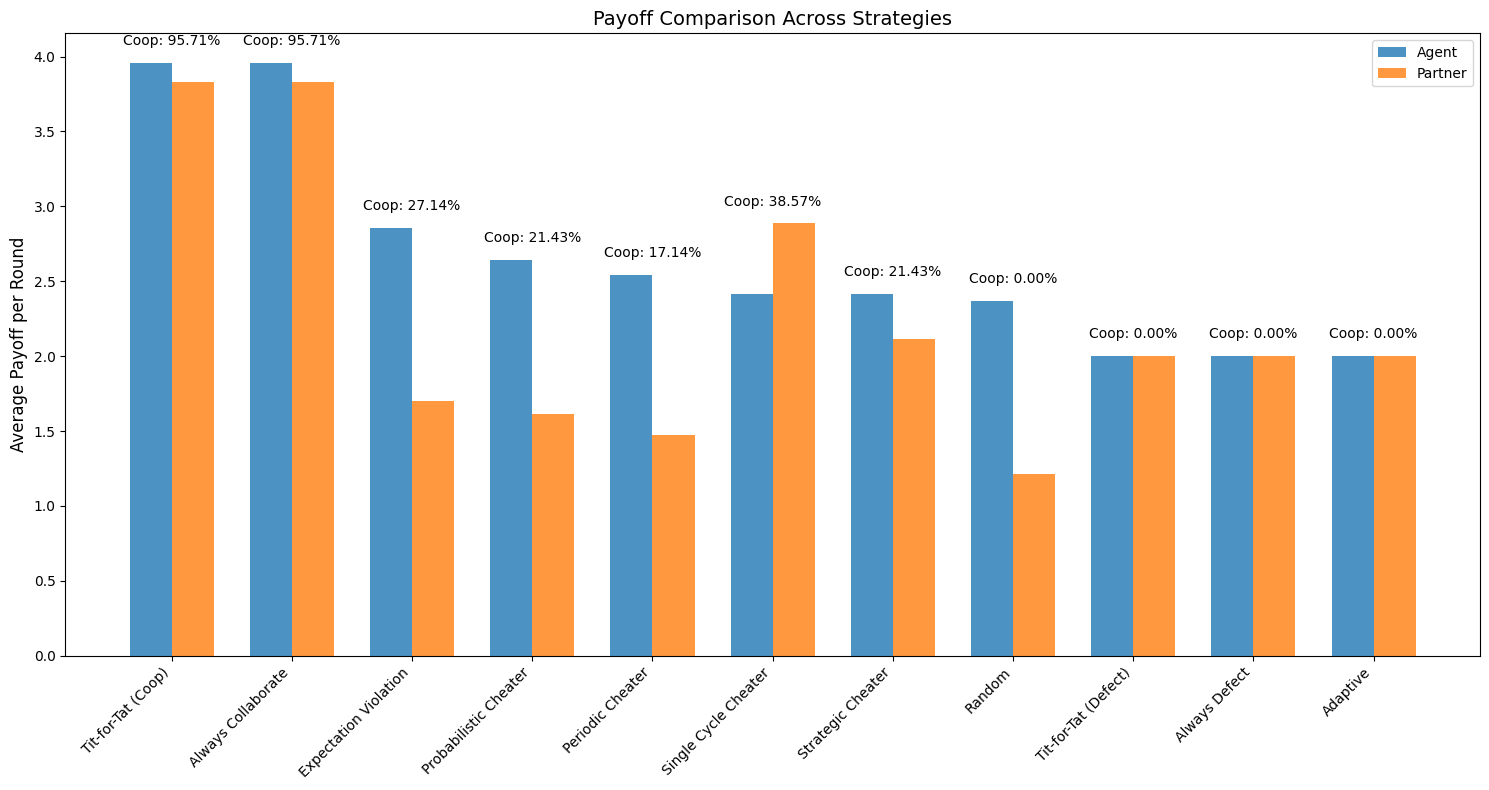


Detailed Strategy Analysis:
             Strategy  Total Agent Payoff  Total Partner Payoff  Avg Agent Payoff  Avg Partner Payoff  Mutual Cooperation Rate
   Tit-for-Tat (Coop)                 277                   268              3.96                3.83                     0.96
   Always Collaborate                 277                   268              3.96                3.83                     0.96
Expectation Violation                 200                   119              2.86                1.70                     0.27
Probabilistic Cheater                 185                   113              2.64                1.61                     0.21
     Periodic Cheater                 178                   103              2.54                1.47                     0.17
 Single Cycle Cheater                 169                   202              2.41                2.89                     0.39
    Strategic Cheater                 169                   148              2.41 

In [17]:
def analyze_payoffs(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze payoffs for a given strategy."""
    df_with_payoff = add_payoffs(df)
    return {
        'Strategy': strategy_name,
        'Total Agent Payoff': df_with_payoff['Agent_Payoff'].sum(),
        'Total Partner Payoff': df_with_payoff['Partner_Payoff'].sum(),
        'Avg Agent Payoff': df_with_payoff['Agent_Payoff'].mean(),
        'Avg Partner Payoff': df_with_payoff['Partner_Payoff'].mean(),
        'Mutual Cooperation Rate': (df_with_payoff['Agent_Choice'] & df_with_payoff['Partner_Choice']).mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_payoffs("Tit-for-Tat (Coop)", df_bayes_collab),
    analyze_payoffs("Tit-for-Tat (Defect)", df_bayes_tft_d),
    analyze_payoffs("Expectation Violation", df_bayes_expect),
    analyze_payoffs("Periodic Cheater", df_bayes_cheating),
    analyze_payoffs("Single Cycle Cheater", df_bayes_cheating_partner_cycle),
    analyze_payoffs("Probabilistic Cheater", df_bayes_prob),
    analyze_payoffs("Strategic Cheater", df_bayes_strat),
    analyze_payoffs("Always Collaborate", df_bayes_collab),
    analyze_payoffs("Always Defect", df_bayes_defect),
    analyze_payoffs("Random", df_bayes_random),
    analyze_payoffs("Adaptive", df_bayes_adaptive)
])

# Sort by total agent payoff to see most successful strategies
strategy_results = strategy_results.sort_values('Total Agent Payoff', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Avg Agent Payoff'], width, label='Agent', alpha=0.8)
plt.bar(x + width/2, strategy_results['Avg Partner Payoff'], width, label='Partner', alpha=0.8)

plt.ylabel('Average Payoff per Round', fontsize=12)
plt.title('Payoff Comparison Across Strategies', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add cooperation rate as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._4, row._5) + 0.1, 
             f'Coop: {row._6:.2%}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Strategy Analysis:")
print(strategy_results.round(2).to_string(index=False))

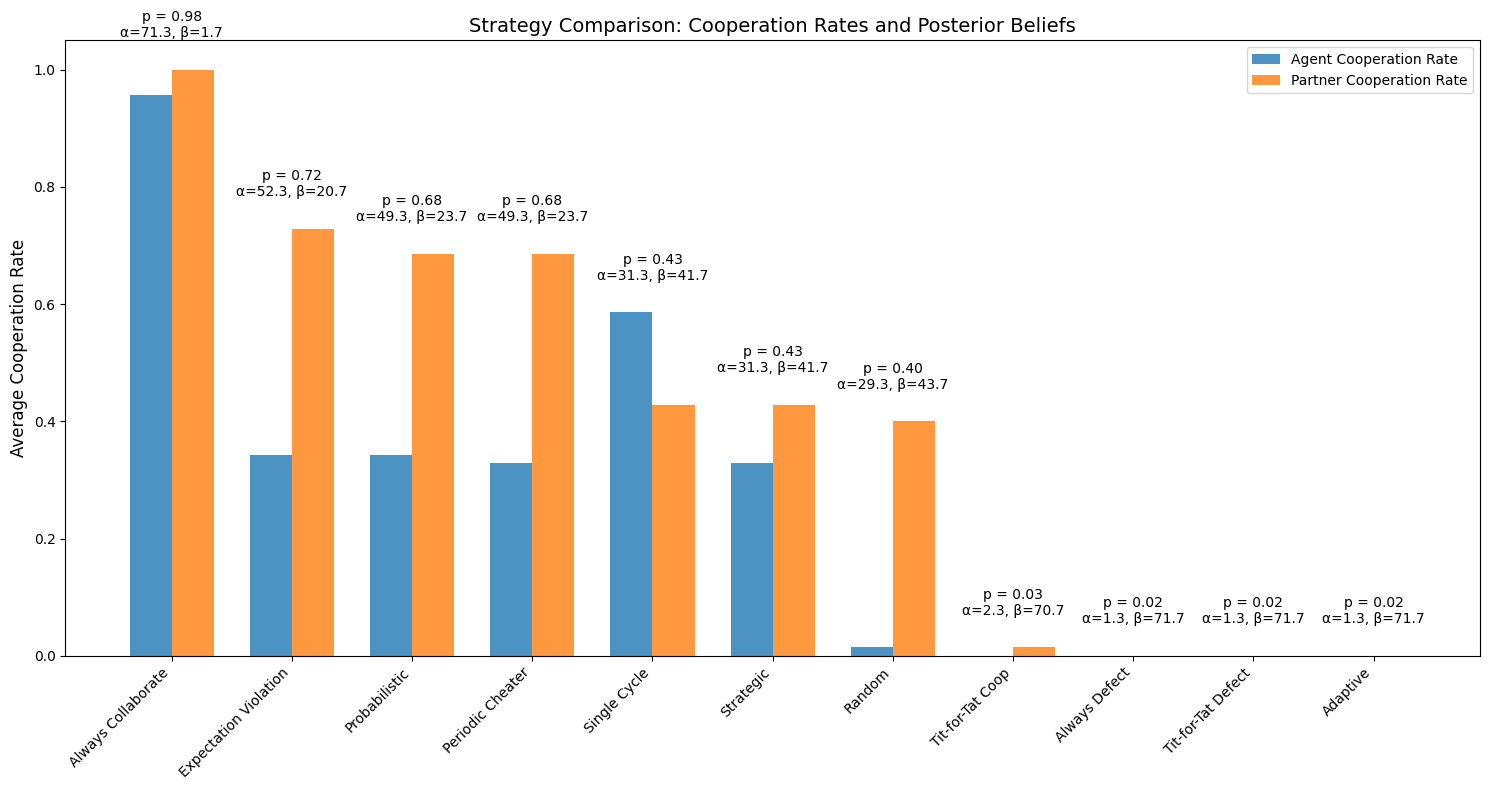


Detailed Bayesian Analysis:
             Strategy  Final Alpha  Final Beta  Final Posterior Mean  Final Concentration  Mutual Cooperation Rate  Agent Cooperation Rate  Partner Cooperation Rate
   Always Collaborate       71.333       1.667                 0.977                 71.0                    0.957                   0.957                     1.000
Expectation Violation       52.333      20.667                 0.717                 71.0                    0.271                   0.343                     0.729
        Probabilistic       49.333      23.667                 0.676                 71.0                    0.214                   0.343                     0.686
     Periodic Cheater       49.333      23.667                 0.676                 71.0                    0.171                   0.329                     0.686
         Single Cycle       31.333      41.667                 0.429                 71.0                    0.386                   0.586        

In [18]:
def analyze_bayesian_results(strategy_name: str, df: pd.DataFrame) -> dict:
    """Analyze results for a given strategy with Bayesian agent."""
    return {
        'Strategy': strategy_name,
        'Final Alpha': df['Alpha'].iloc[-1],
        'Final Beta': df['Beta'].iloc[-1],
        'Final Posterior Mean': df['Posterior_Mean'].iloc[-1],
        'Final Concentration': df['Concentration'].iloc[-1],
        'Mutual Cooperation Rate': (df['Agent_Choice'] & df['Partner_Choice']).mean(),
        'Agent Cooperation Rate': df['Agent_Choice'].mean(),
        'Partner Cooperation Rate': df['Partner_Choice'].mean()
    }

# Analyze all strategies
strategy_results = pd.DataFrame([
    analyze_bayesian_results("Always Collaborate", df_bayes_collab),
    analyze_bayesian_results("Always Defect", df_bayes_defect),
    analyze_bayesian_results("Random", df_bayes_random),
    analyze_bayesian_results("Probabilistic", df_bayes_prob),
    analyze_bayesian_results("Periodic Cheater", df_bayes_cheating),
    analyze_bayesian_results("Single Cycle", df_bayes_cheating_partner_cycle),
    analyze_bayesian_results("Tit-for-Tat Coop", df_bayes_tft_c),
    analyze_bayesian_results("Tit-for-Tat Defect", df_bayes_tft_d),
    analyze_bayesian_results("Adaptive", df_bayes_adaptive),
    analyze_bayesian_results("Strategic", df_bayes_strat),
    analyze_bayesian_results("Expectation Violation", df_bayes_expect)
])

# Sort by posterior mean to see most "trusted" strategies
strategy_results = strategy_results.sort_values('Final Posterior Mean', ascending=False)

# Create visualization
plt.figure(figsize=(15, 8))
x = np.arange(len(strategy_results))
width = 0.35

plt.bar(x - width/2, strategy_results['Agent Cooperation Rate'], width, 
       label='Agent Cooperation Rate', alpha=0.8)
plt.bar(x + width/2, strategy_results['Partner Cooperation Rate'], width,
       label='Partner Cooperation Rate', alpha=0.8)

plt.ylabel('Average Cooperation Rate', fontsize=12)
plt.title('Strategy Comparison: Cooperation Rates and Posterior Beliefs', fontsize=14)
plt.xticks(x, strategy_results['Strategy'], rotation=45, ha='right')
plt.legend()

# Add posterior mean as text on top of bars
for i, row in enumerate(strategy_results.itertuples()):
    plt.text(i, max(row._7, row._8) + 0.05,  # Using index positions since column names changed
             f'p = {row._4:.2f}\nα={row._2:.1f}, β={row._3:.1f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Bayesian Analysis:")
print(strategy_results.round(3).to_string(index=False))